In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import const as CONST
from utils import read_csv_ts
from darts import TimeSeries
import matplotlib
from datasets import SeqDataset, Datasets, DatasetAccesor, DatasetTransformer, load_datasets
import seaborn as sns

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (20, 10)
COLORS = [
    "red", "green", "blue", "purple", "cyan", "olive", "gray", "brown", "pink",
]

In [18]:
ds = load_datasets()

INFO:Dataset:Loading dataset from data/preprocessed/datasets.pkl


In [19]:
print(f"Data starts: {ds.original.series[0].start_time()}")
print(f"Data ends: {ds.original.series[0].end_time()}, len = {len(ds.original.series[0])}")
print(f"Train data starts: {ds.original.train[0].start_time()}, len = {len(ds.original.train[0])}")
print(f"Validation data starts: {ds.original.val[0].start_time()}, len = {len(ds.original.val[0])}")
print(f"Test data starts: {ds.original.test[0].start_time()}, len = {len(ds.original.test[0])}")

Data starts: 2008-01-02 00:00:00
Data ends: 2023-03-10 00:00:00, len = 3824
Train data starts: 2008-01-02 00:00:00, len = 3059
Validation data starts: 2020-02-27 00:00:00, len = 382
Test data starts: 2021-09-01 00:00:00, len = 383


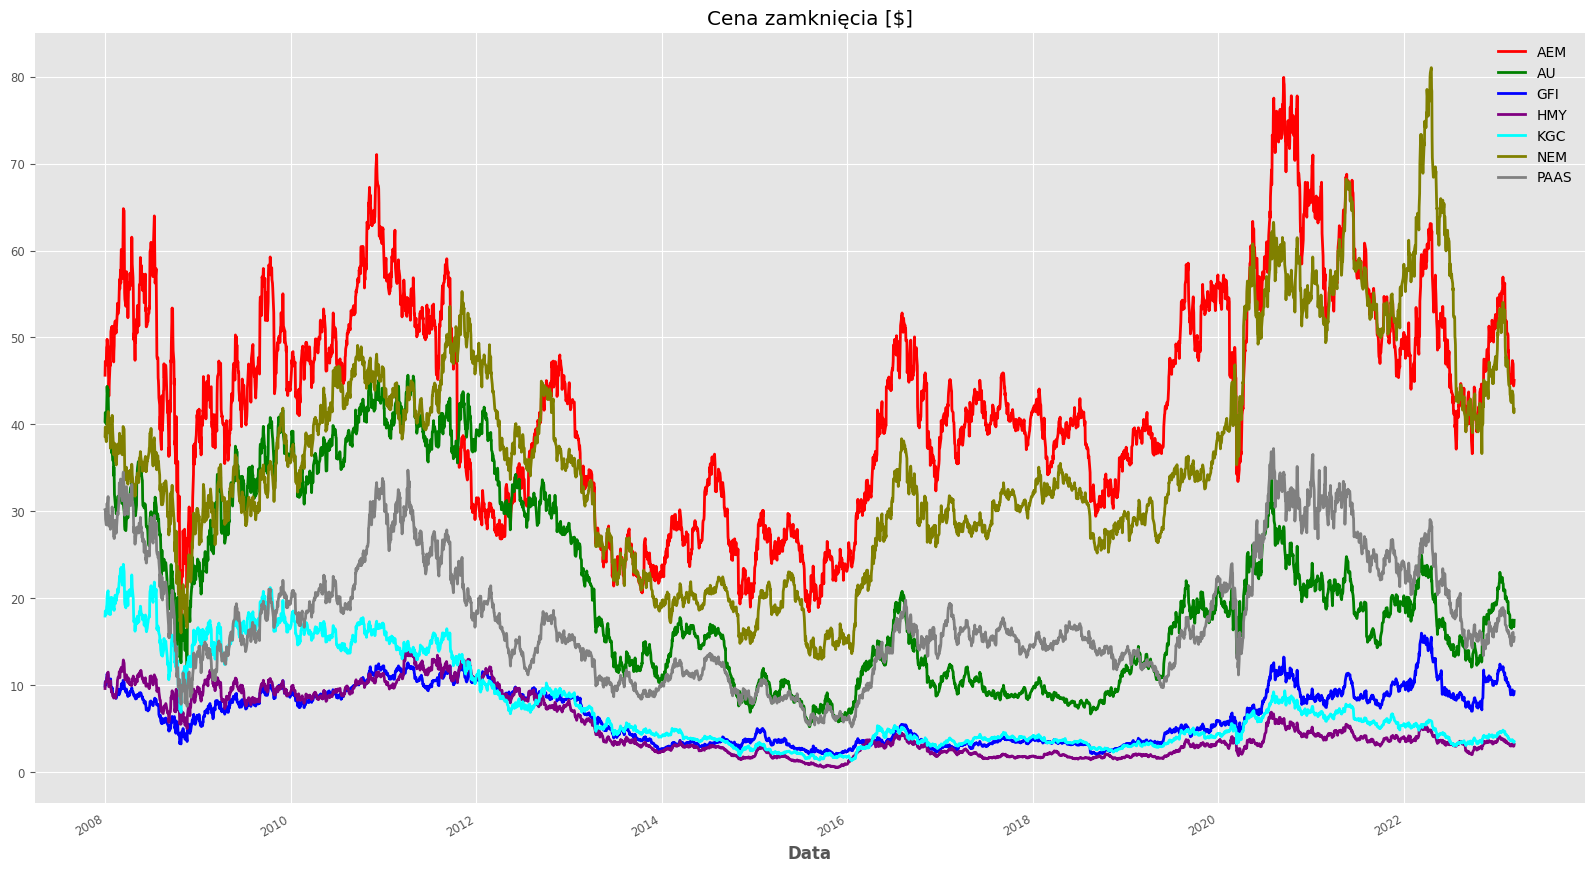

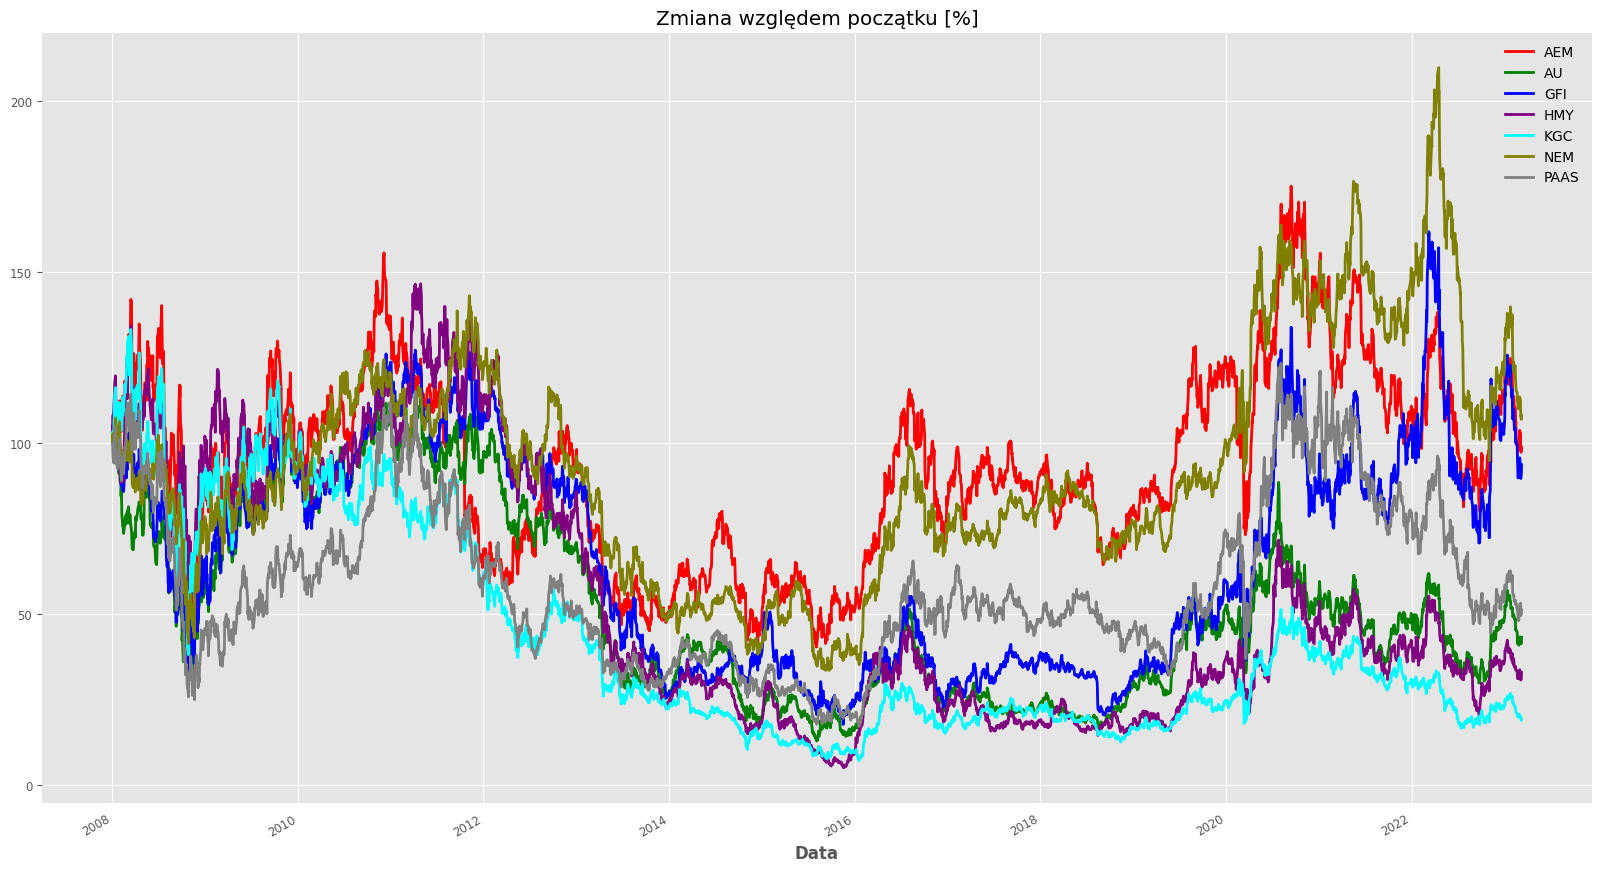

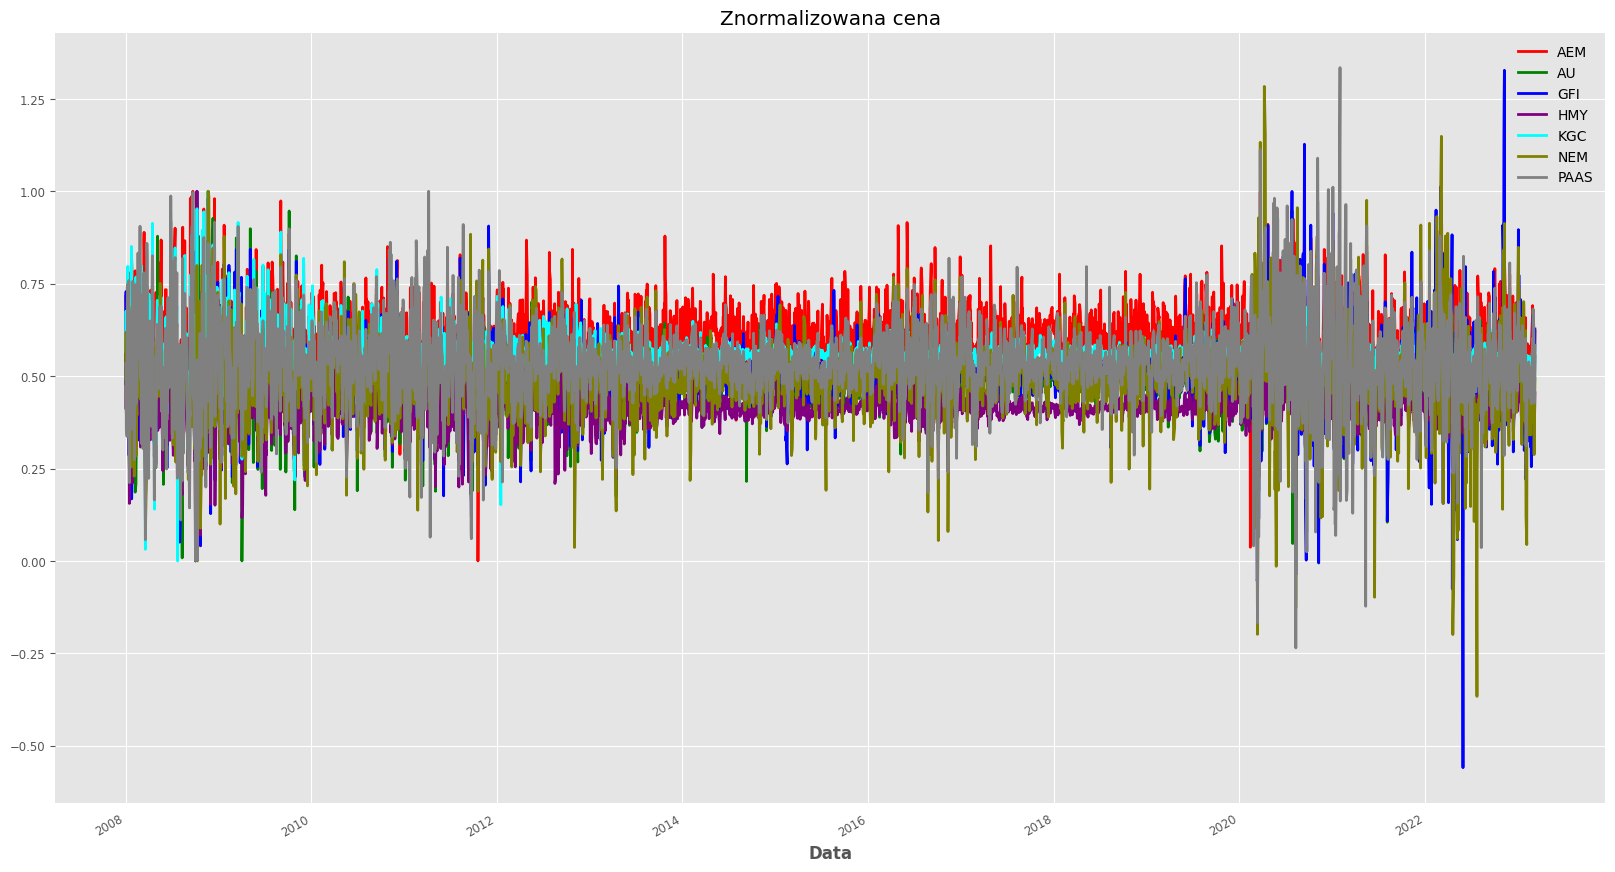

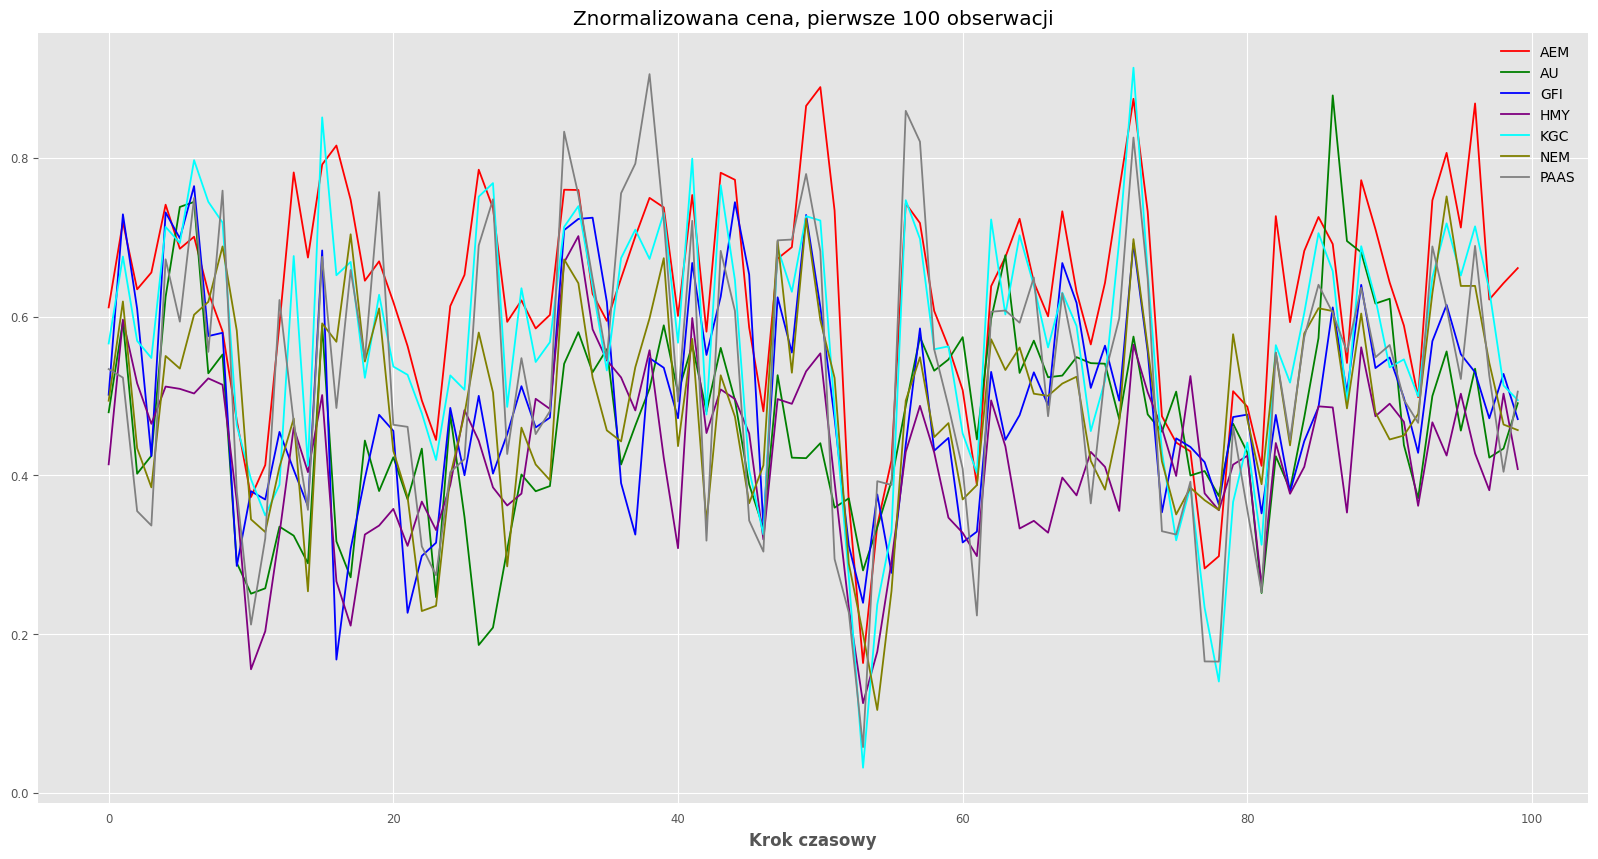

In [20]:
for idx,ticker in enumerate(ds.original.used_tickers):
    ds.original.series[idx].plot(label=ticker,color = COLORS[idx])

plt.title("Cena zamknięcia [$]")
plt.xlabel("Data")
plt.show()

for idx,ticker in enumerate(ds.original.used_tickers):
    (100* ds.original.series[idx]/ ds.original.series[idx].first_value()).plot(label=ticker, color = COLORS[idx])
plt.title("Zmiana względem początku [%]")
plt.xlabel("Data")
plt.show()

for idx,ticker in enumerate(ds.original.used_tickers):
    ds.transformed.series[idx].plot(label=ticker,color = COLORS[idx])
plt.title("Znormalizowana cena")
plt.xlabel("Data")
plt.show()


for idx,ticker in enumerate(ds.original.used_tickers):
    plt.plot(ds.transformed.series[idx][0:100].values(),label=ticker,color = COLORS[idx])
plt.legend(ds.original.used_tickers)
plt.title("Znormalizowana cena, pierwsze 100 obserwacji")
plt.xlabel("Krok czasowy")
plt.show()

In [21]:
my_dict = dict(zip(CONST.TICKERS,[x.pd_series().pct_change().values[1:] * 100 for x in ds.original.train]))
df = pd.DataFrame(my_dict)
df.describe()

,AEM,AU,GFI,HMY,KGC,NEM,PAAS
count,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000
mean,0.048240,0.030365,0.045228,0.043445,0.018514,0.035961,0.042508
std,3.073396,3.302423,3.475789,3.836371,3.413099,2.523381,3.216015
min,-25.180847,-19.677401,-22.169840,-18.750000,-18.814241,-14.092344,-21.349644
25%,-1.453932,-1.693723,-1.744770,-2.150542,-1.776010,-1.234792,-1.683426
50%,0.000000,-0.069451,0.000000,0.000000,0.000000,0.023443,0.000000
75%,1.540565,1.629058,1.746592,1.983881,1.712626,1.280397,1.767409
max,21.970606,43.034340,36.960613,34.766113,29.053450,25.173903,30.107534


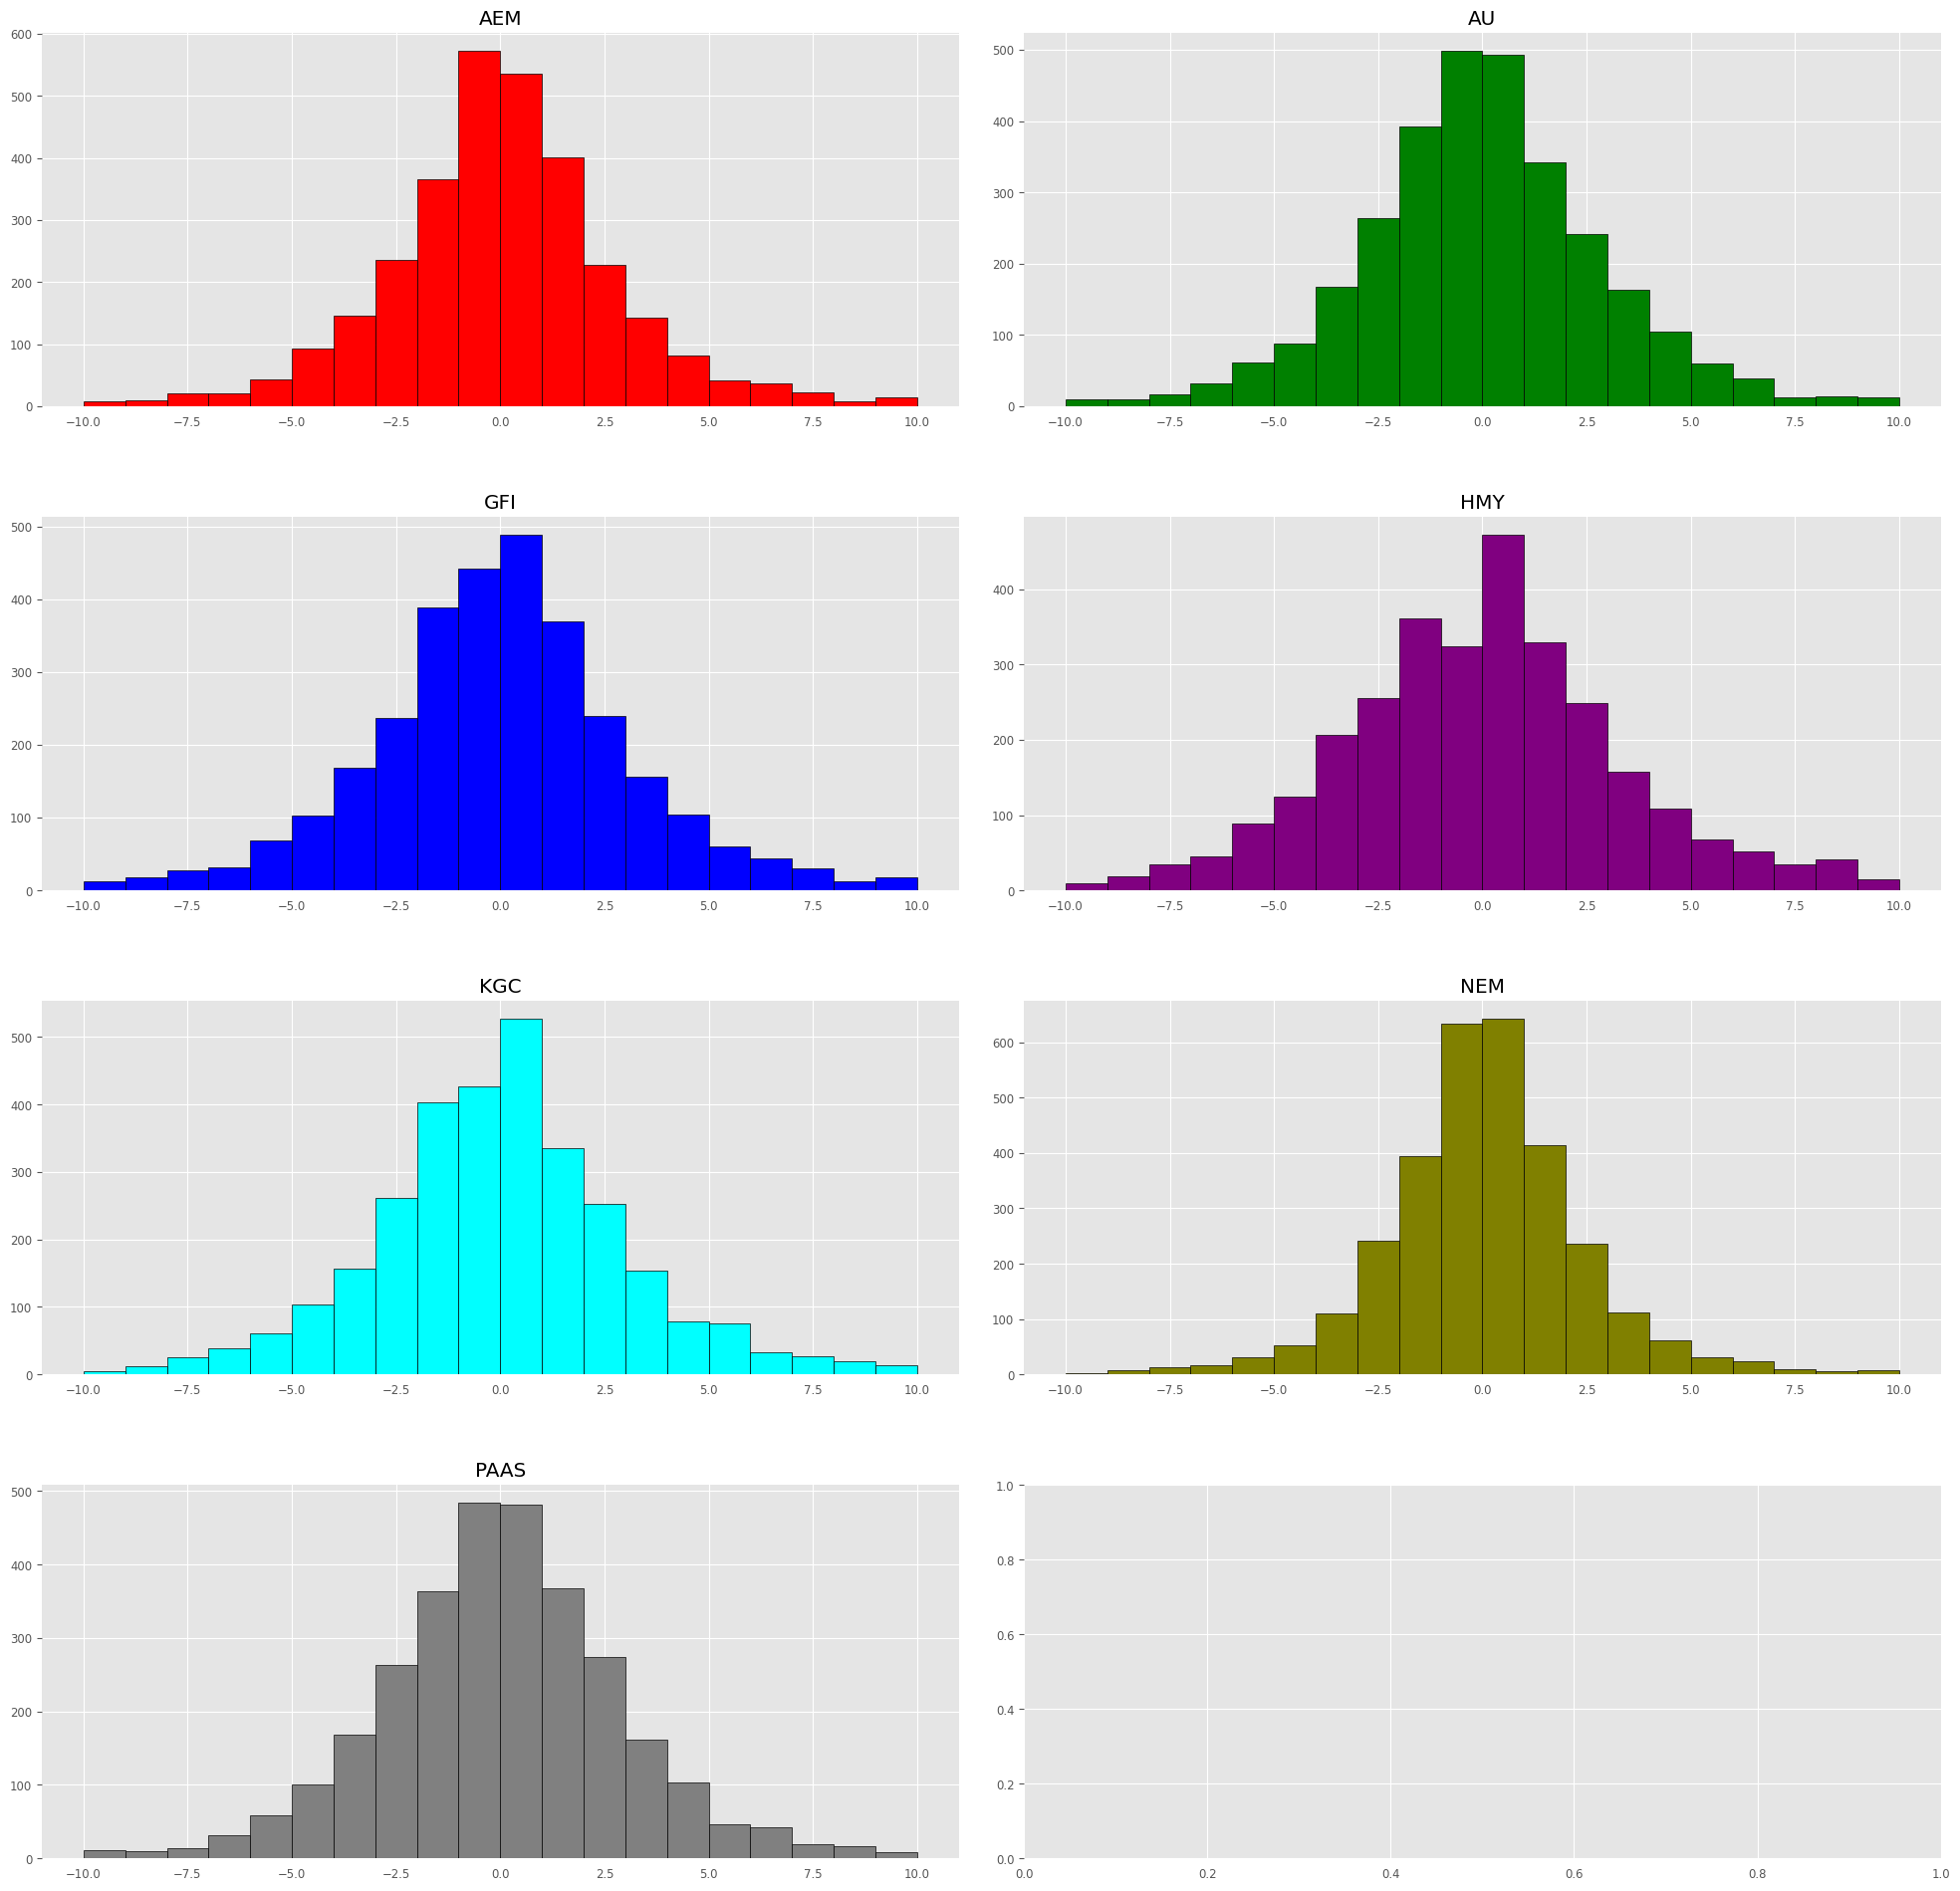

In [22]:
# Dystrybucja zmian w cenie
bins= [x  for x in range(-10,11)]
figure, axis = plt.subplots(4, 2)
figure.tight_layout(pad=2.0)

figure.set_figheight(20)
for idx,ticker in enumerate(df):
    axis[idx // 2, idx % 2].hist(df[ticker], bins= bins, color=COLORS[idx], edgecolor='black')
    axis[idx // 2, idx % 2].set_title(ticker)

plt.show()

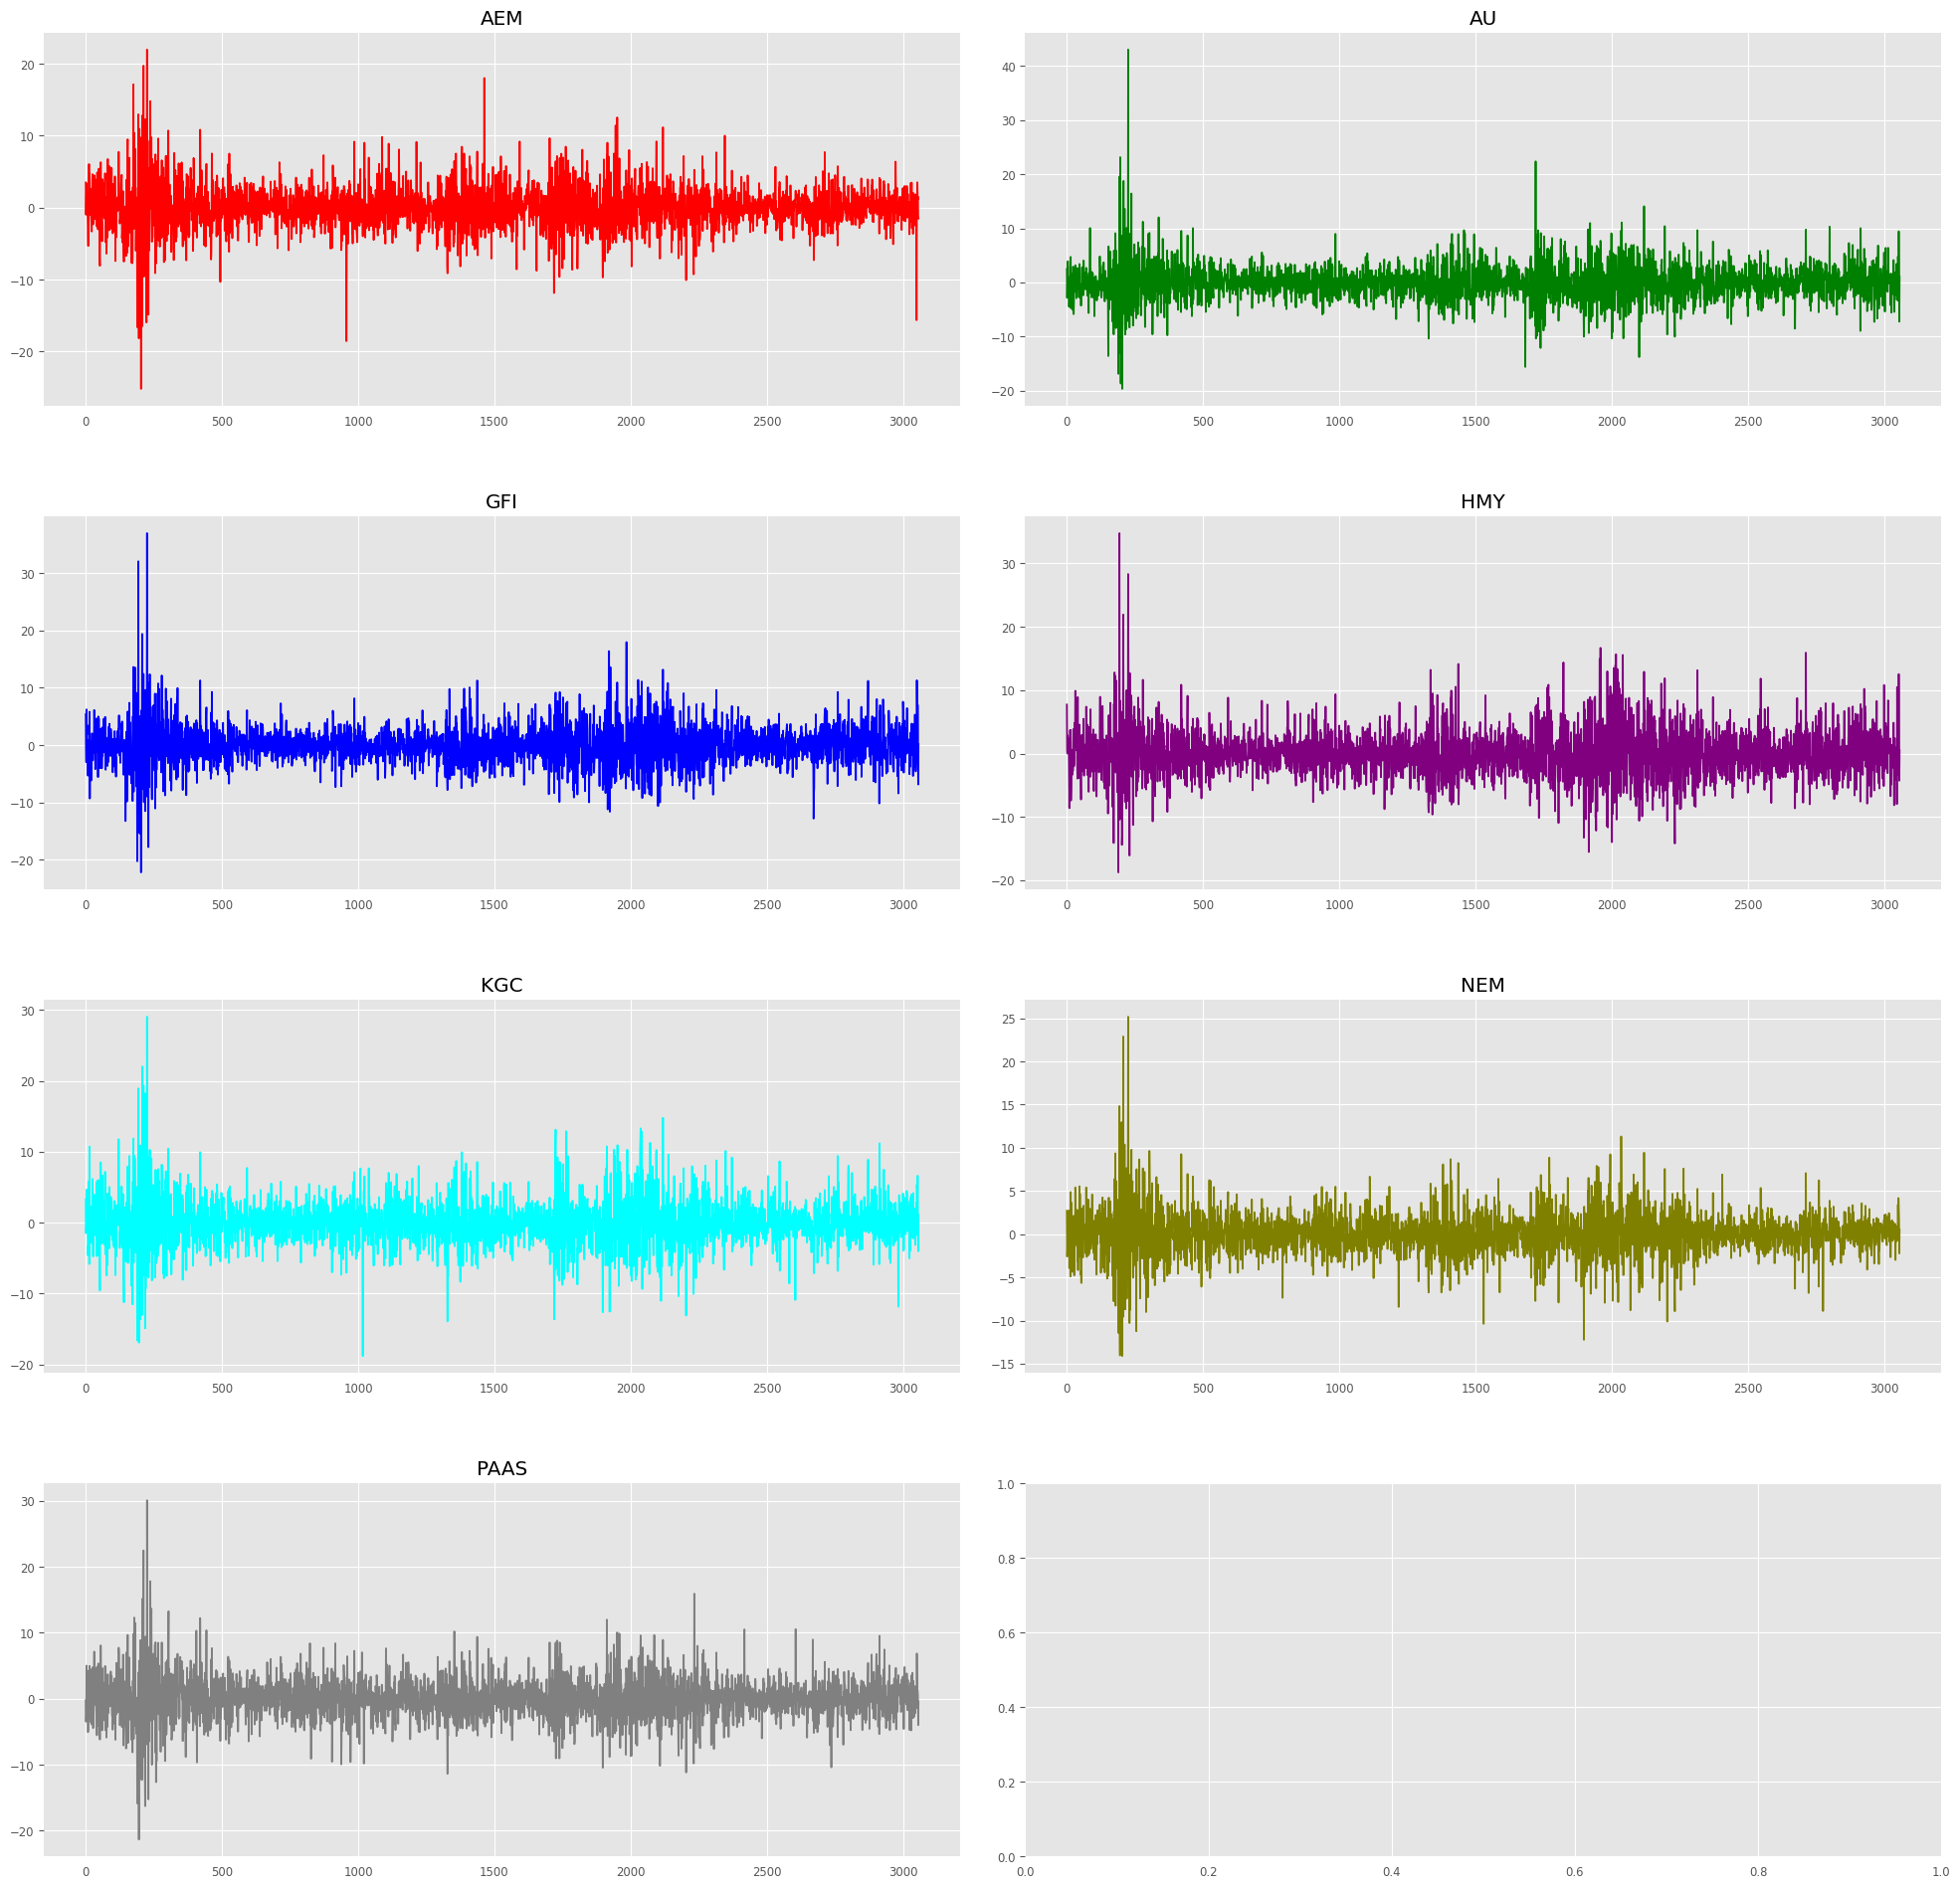

In [23]:
figure, axis = plt.subplots(4, 2)
figure.tight_layout(pad=2.0)
figure.set_figheight(20)
for idx,ticker in enumerate(df):
    axis[idx // 2, idx % 2].plot(df[ticker], color=COLORS[idx])
    axis[idx // 2, idx % 2].set_title(ticker)

plt.show()

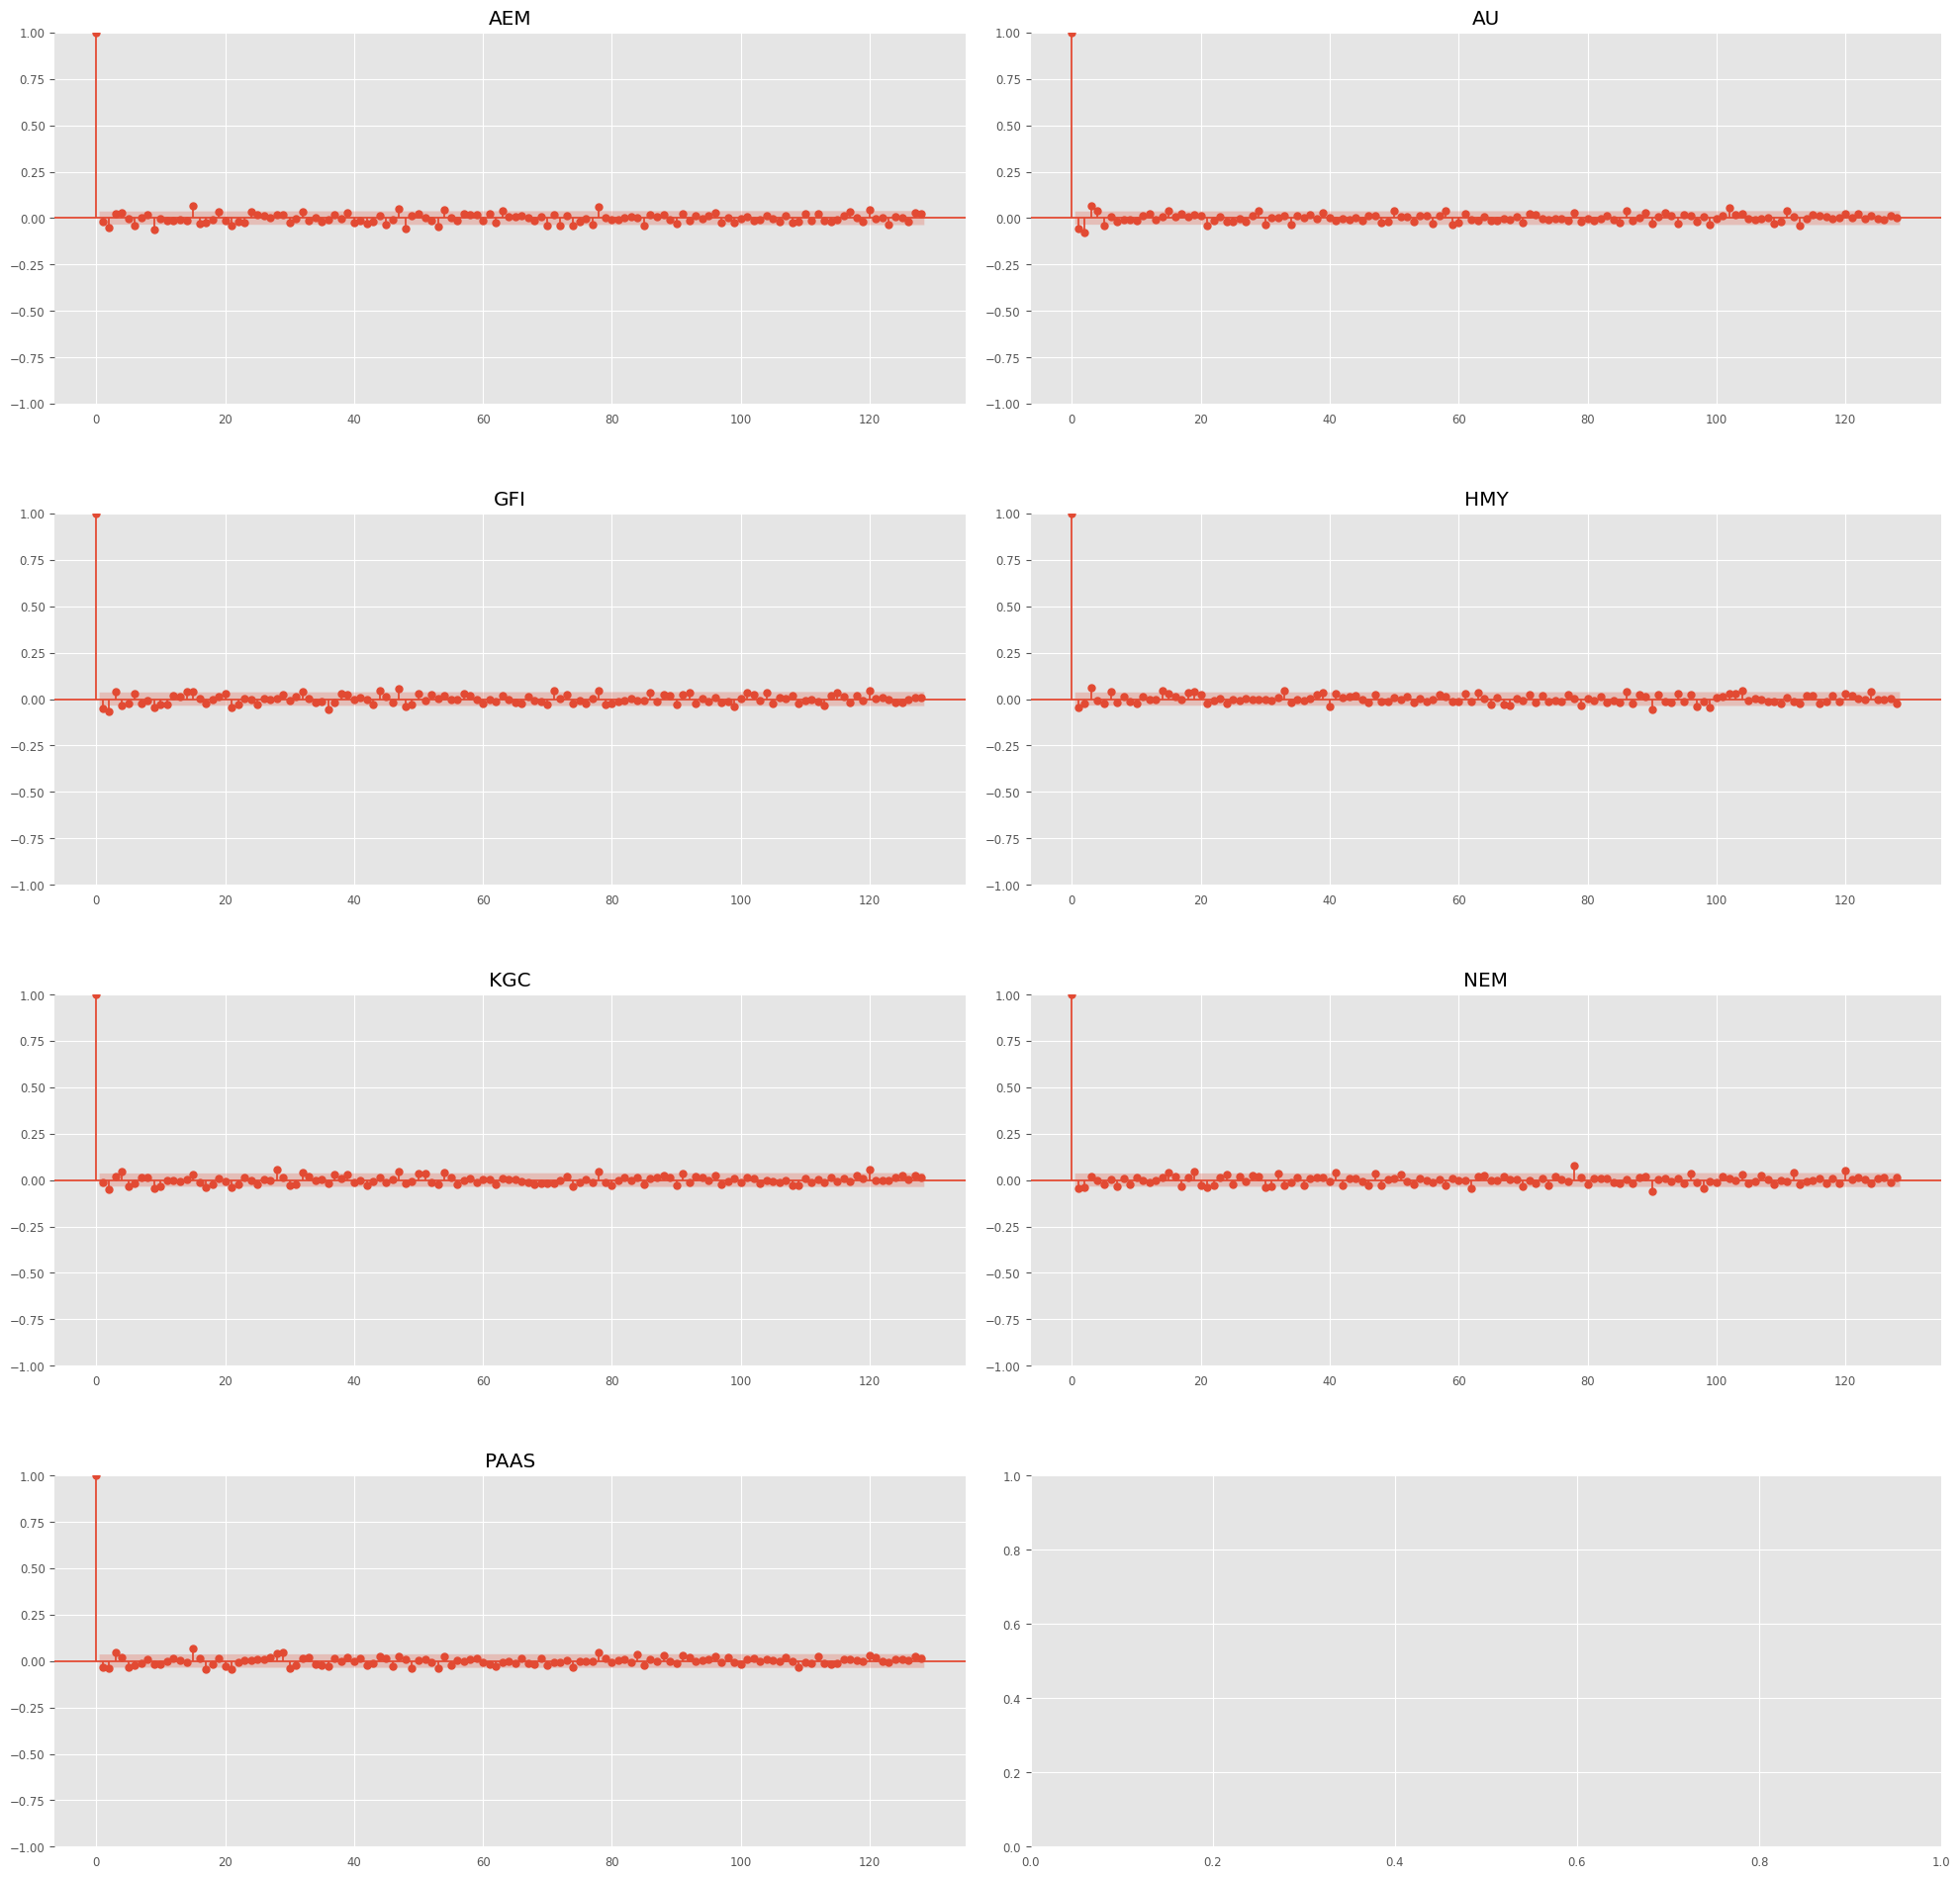

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_from_df(df):
    figure, axis = plt.subplots(4, 2)
    figure.tight_layout(pad=2.0)
    figure.set_figheight(20)
    for idx, ticker in enumerate(df):
        plot_acf(ax= axis[idx // 2, idx % 2],x = df[ticker], lags=128, title=ticker)
    plt.show()

plot_acf_from_df(df)

In [25]:
import darts.utils.statistics as statistics
# Stationary 
stats_df = pd.DataFrame({ CONST.FEATURES.PRICE: [] })
p_threshold = 0.05
def test_stationarity(timeseries: TimeSeries):
    return statistics.stationarity_test_adf(TimeSeries.from_series(timeseries))[1]

for idx,ticker in enumerate(df):
    price_stationarity = test_stationarity(df[ticker])
    stats_df.loc[ticker] = price_stationarity

print(stats_df)
print(stats_df < p_threshold)

          adjclose
AEM   8.312115e-23
AU    0.000000e+00
GFI   1.850438e-26
HMY   0.000000e+00
KGC   2.048531e-30
NEM   0.000000e+00
PAAS  9.632960e-17
      adjclose
AEM       True
AU        True
GFI       True
HMY       True
KGC       True
NEM       True
PAAS      True


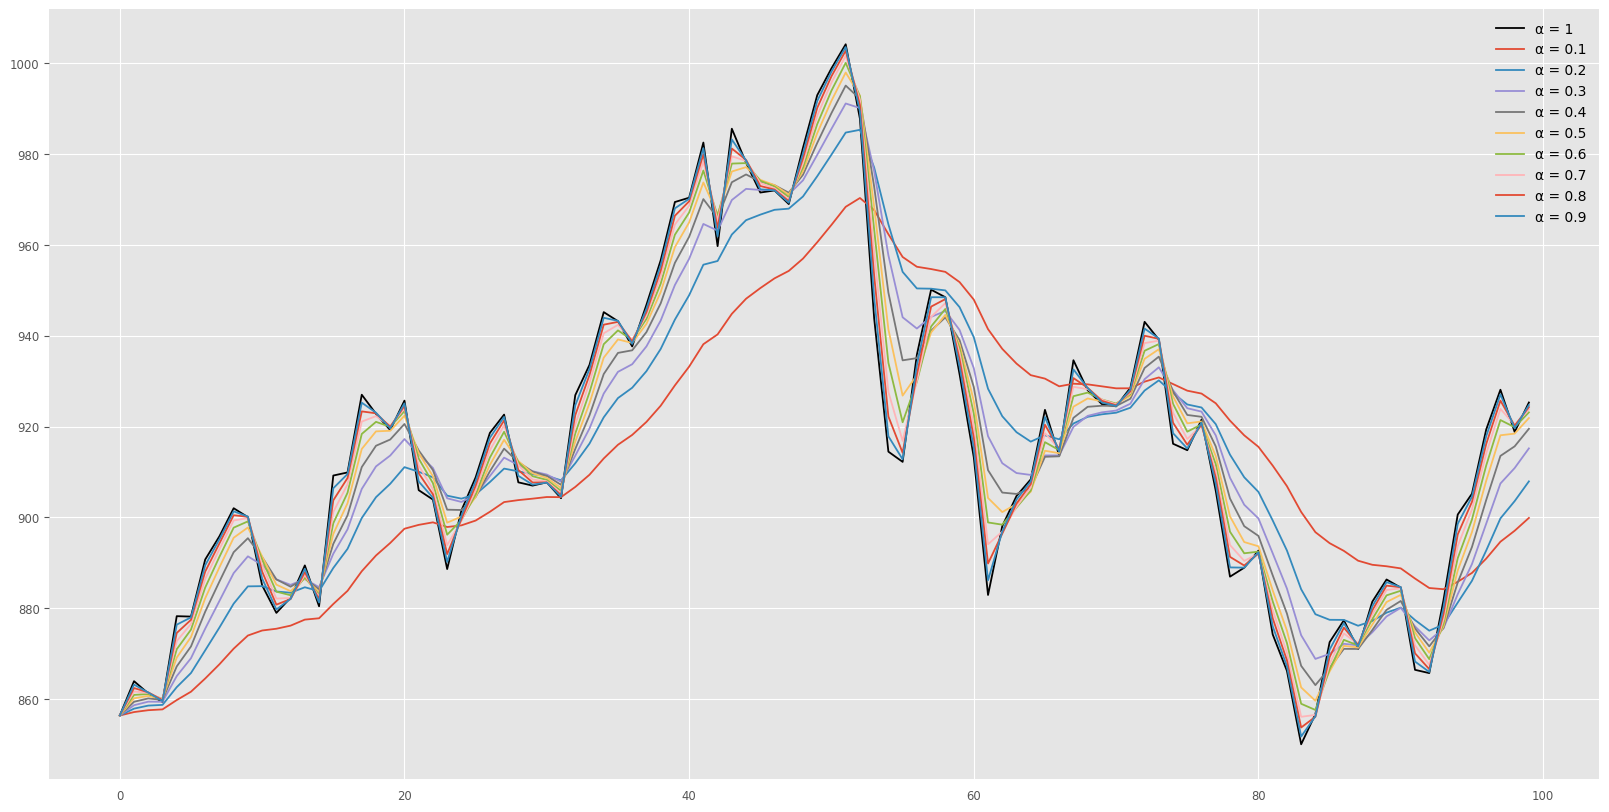

In [26]:
from smoothing import smooth

gold_ts = TimeSeries.from_dataframe(read_csv_ts("data/daily/GOLD.csv")[["adjclose"]])

series = gold_ts[0:100]
plt.plot(range(0,100), series.values(), label=f"α = {1}", color="black")
for i in range (1,10):
    alpha = i / 10
    smoothed = smooth(series, alpha)
    plt.plot(range(0,100), smoothed.values(), label=f"α = {alpha}")


plt.legend(loc="upper right")
plt.show()

In [27]:
cov_df = ds.covariates.train[0].pd_dataframe()
cov_df.drop("volume",axis=1, inplace=True)
cov_df

component,month_sin,month_cos,weekday_sin,weekday_cos,INFLATION,^GSPC,ES=F,GC=F,GOLD,SI=F,SILVER,XLF
date,,,,,,,,,,,,
2008-01-02,0.500000,0.866025,0.974928,-0.222521,0.561265,0.691291,0.673270,0.677225,0.662945,0.778848,0.726148,0.484035
2008-01-03,0.500000,0.866025,0.433884,-0.900969,0.561265,0.691291,0.674183,0.714016,0.692125,0.799010,0.747055,0.452160
2008-01-04,0.500000,0.866025,-0.433884,-0.900969,0.561265,0.540826,0.543221,0.682704,0.667113,0.785553,0.729284,0.326414
2008-01-07,0.500000,0.866025,0.000000,1.000000,0.561265,0.635328,0.602770,0.666266,0.657695,0.766634,0.715172,0.417622
2008-01-08,0.500000,0.866025,0.781832,0.623490,0.561265,0.553244,0.548583,0.743761,0.733347,0.822161,0.775019,0.273725
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-20,0.866025,0.500000,0.433884,-0.900969,0.561276,0.665640,0.634277,0.749982,0.736471,0.799314,0.745807,0.482697
2020-02-21,0.866025,0.500000,-0.433884,-0.900969,0.561271,0.528212,0.544259,0.823193,0.791340,0.808962,0.749881,0.400679
2020-02-24,0.866025,0.500000,0.000000,1.000000,0.561268,0.136036,0.196258,0.859016,0.789053,0.826445,0.752650,0.166733


In [28]:
cov_df.describe()

component,month_sin,month_cos,weekday_sin,weekday_cos,INFLATION,^GSPC,ES=F,GC=F,GOLD,SI=F,SILVER,XLF
count,3.059000e+03,3.059000e+03,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000
mean,-1.050278e-03,-1.590722e-03,0.361081,-0.092018,0.561039,0.696043,0.677334,0.679239,0.664923,0.779029,0.726348,0.485987
std,7.073950e-01,7.070472e-01,0.515715,0.771669,0.024358,0.087376,0.076428,0.063246,0.061021,0.050544,0.054580,0.077107
min,-1.000000e+00,-1.000000e+00,-0.433884,-0.900969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.660254e-01,-6.830127e-01,0.000000,-0.900969,0.561225,0.657385,0.644505,0.647571,0.633573,0.760635,0.706493,0.453450
50%,1.224647e-16,6.123234e-17,0.433884,-0.222521,0.561265,0.705129,0.685393,0.681009,0.666327,0.779395,0.727179,0.490911
75%,5.000000e-01,5.000000e-01,0.781832,0.623490,0.561301,0.744231,0.719442,0.714323,0.698941,0.800191,0.748853,0.525513
max,1.000000e+00,1.000000e+00,0.974928,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
df_dict = {}
for x,ticker in zip(ds.transformed.train, CONST.TICKERS):
    df_dict[ticker] = x.pd_series()
df_targets = pd.DataFrame.from_dict(df_dict)
df_targets

,AEM,AU,GFI,HMY,KGC,NEM,PAAS
date,,,,,,,
2008-01-02,0.611500,0.479352,0.501437,0.413761,0.566018,0.493928,0.533788
2008-01-03,0.718919,0.593939,0.728790,0.596018,0.675589,0.618960,0.523024
2008-01-04,0.634285,0.401955,0.609634,0.515869,0.569338,0.434052,0.354799
2008-01-07,0.655443,0.424571,0.424054,0.464815,0.547756,0.384743,0.336633
2008-01-08,0.740891,0.624847,0.731189,0.511752,0.712943,0.550281,0.672066
...,...,...,...,...,...,...,...
2020-02-20,0.644679,0.457938,0.554955,0.446608,0.602614,0.771499,0.689374
2020-02-21,0.662525,0.672926,0.715067,0.539723,0.648704,0.775467,0.660227
2020-02-24,0.685591,0.613573,0.661643,0.495792,0.603880,0.722056,0.615838


In [30]:
df_targets.describe()

,AEM,AU,GFI,HMY,KGC,NEM,PAAS
count,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000
mean,0.611569,0.477822,0.500464,0.412847,0.564486,0.494345,0.533025
std,0.088959,0.084649,0.090127,0.061020,0.071709,0.097598,0.097030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.570714,0.439205,0.457306,0.391140,0.544708,0.443966,0.487616
50%,0.612724,0.476991,0.499970,0.411746,0.564747,0.493630,0.534100
75%,0.658786,0.517390,0.541754,0.434694,0.585470,0.546803,0.582079
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


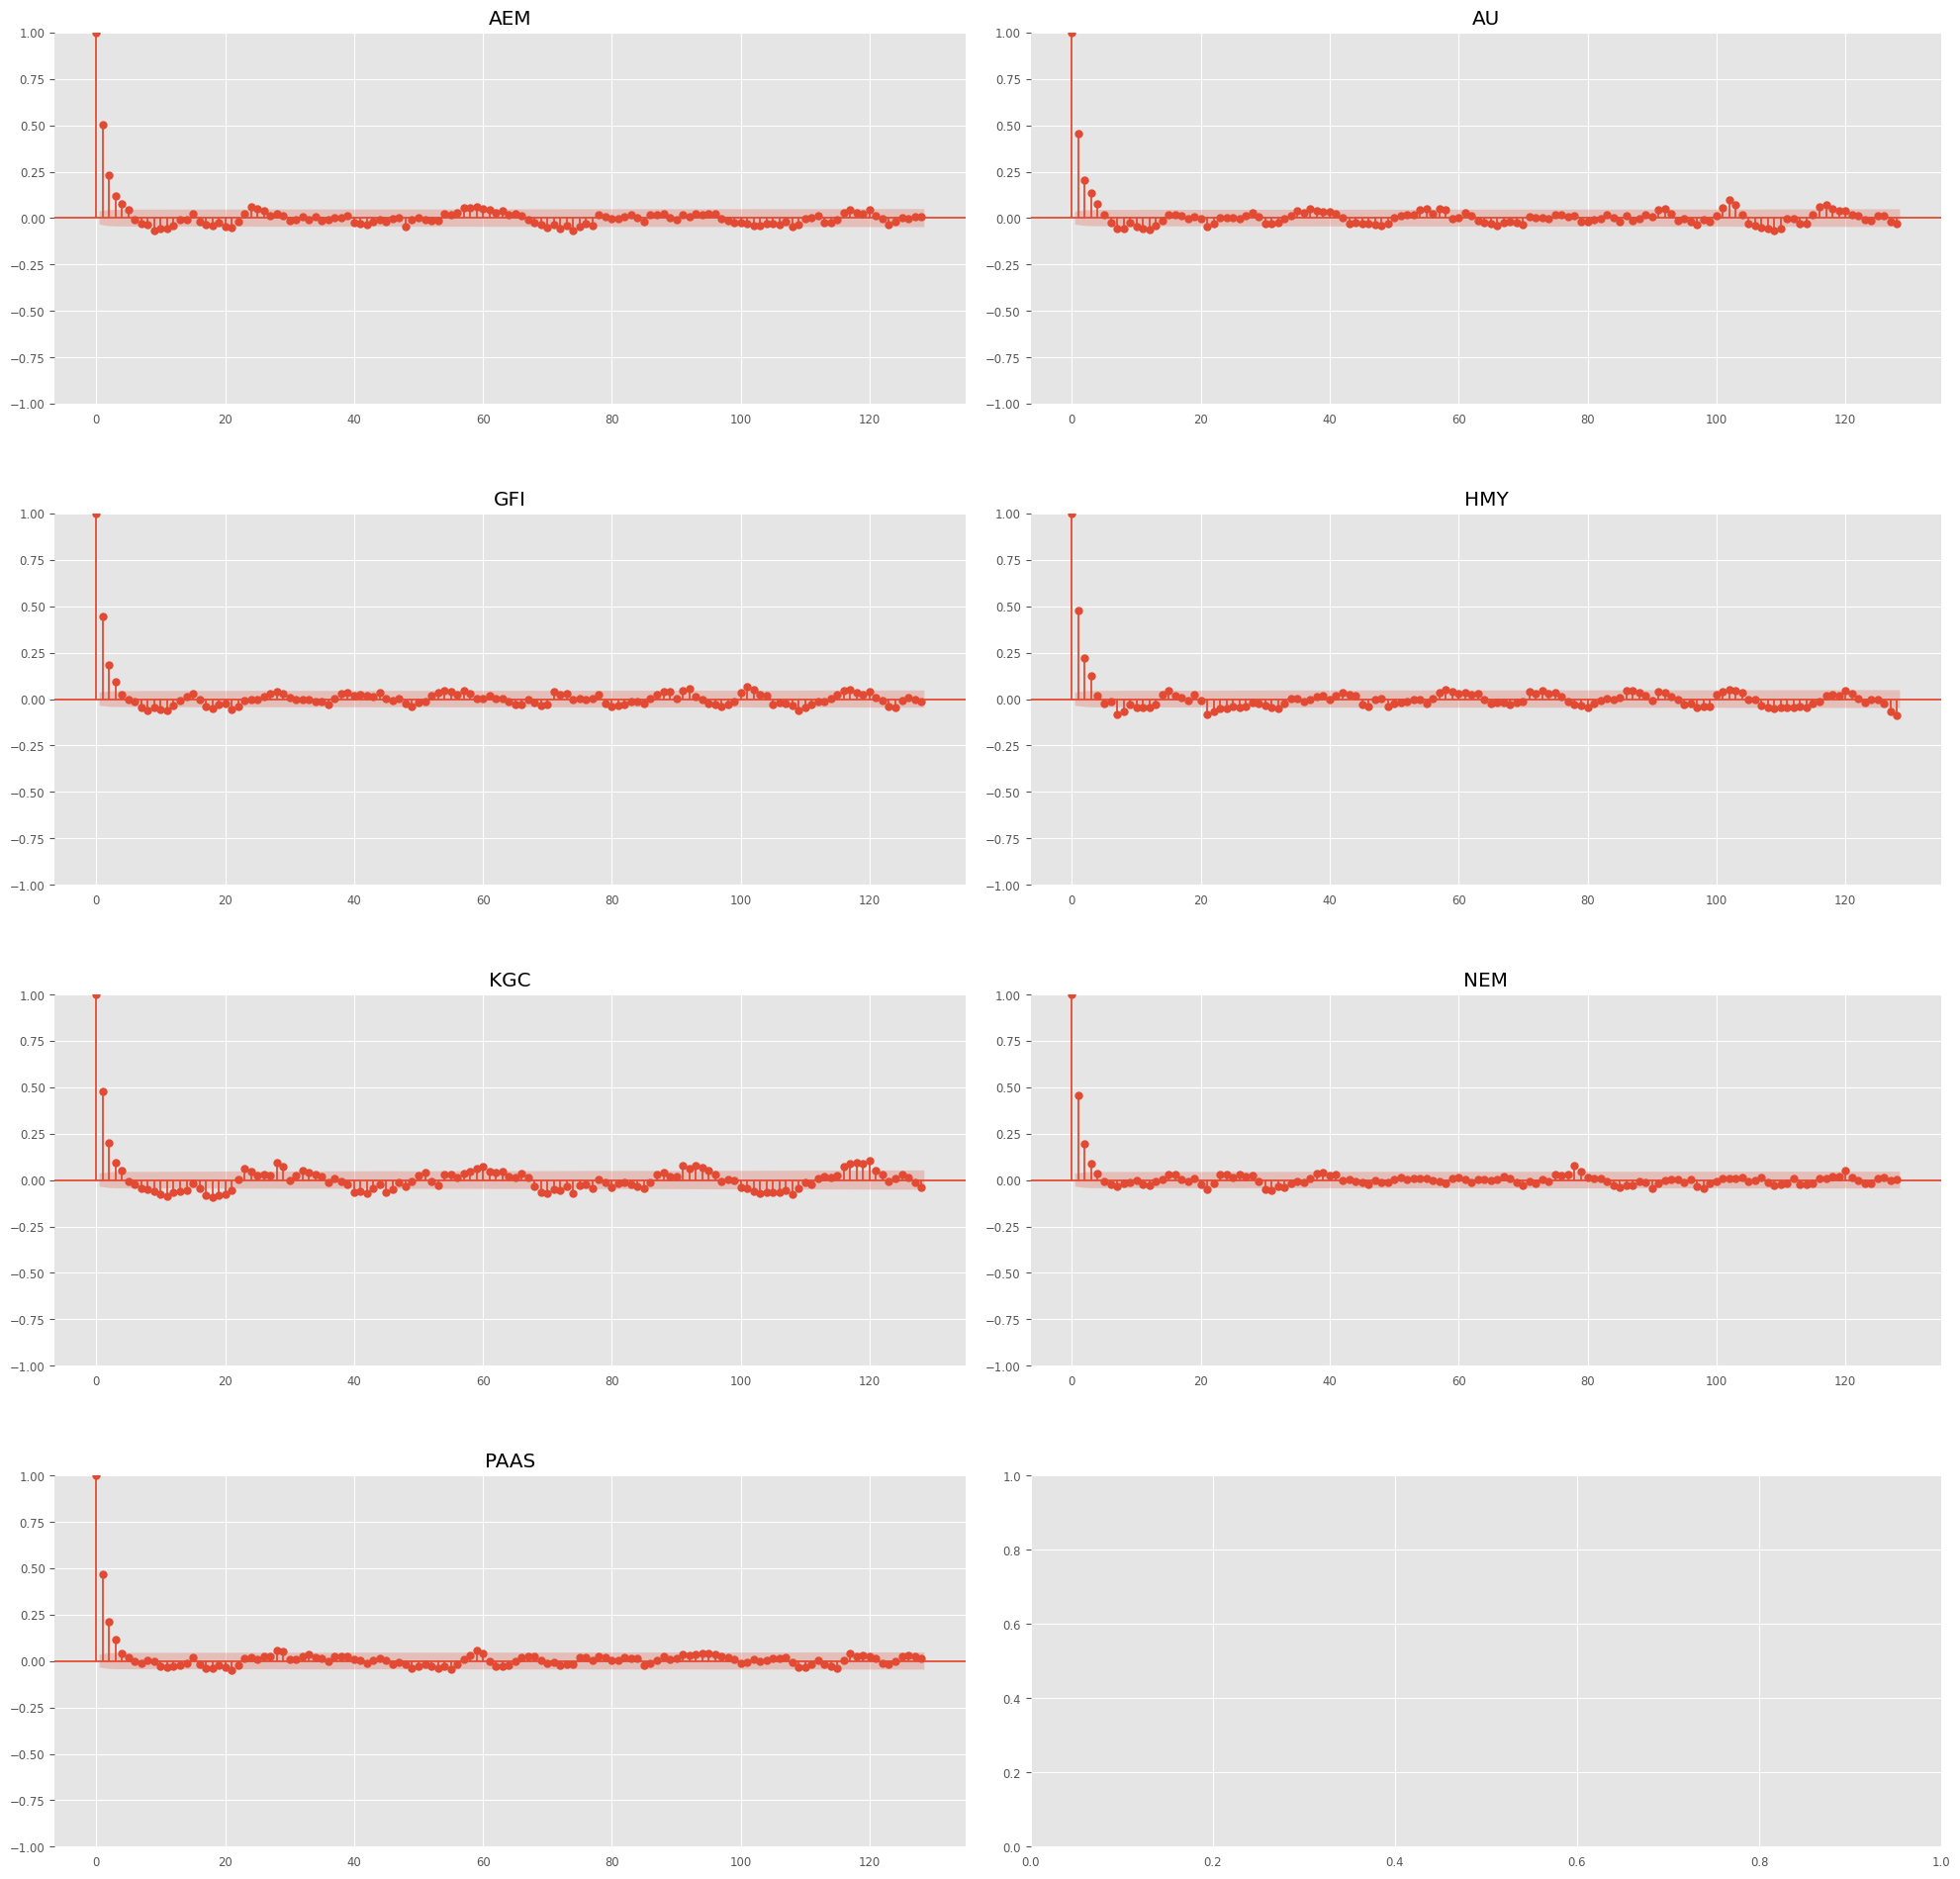

In [31]:
plot_acf_from_df(df_targets)